In [1]:
import sys
sys.path.insert(0, '../models/')
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from Bio import SeqIO
import gensim
import os
import collections
import smart_open
import random
import h5py
import keras
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2 
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import model_from_yaml
from tensorflow.keras.layers import Input,Conv1D, Dense,GRU, LSTM, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation,AveragePooling1D
from tensorflow.keras.initializers import RandomUniform
import keras.backend as K
from random import shuffle
from sklearn.utils import class_weight
import collections
import smart_open
import random
#np.random.seed(1337) # for reproducibility
from random import shuffle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from matplotlib import pyplot as plt
from scipy import interp

In [2]:
model_wv =gensim.models.word2vec.Word2Vec.load('word2vec_pretrained_models/my_word2vec-model-DNA-3mer')

/home/waleed/anaconda3/envs/tf10/lib/python3.7/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
model_wv.corpus_count

279457

In [4]:
######## Read data ###############################
def read_seq_new(seq_file,label):
    seq_list = []
    seq = ''
    with open(seq_file, 'r') as fp:
        for line in fp:
            if line[0] == '>':
                if len(seq):
                    seq = seq.upper()
                    seq_list.append(seq)                    
                seq = ''
            else:
                seq = seq + line[:-1]
        
        if len(seq):
            seq_list.append(seq) 
    seq_data=[]
    all_data=[]
    for s in seq_list:
        tmp=s[0:200]
        seq_data.append(tmp)
        all_data.append([label])
    return seq_data, all_data


In [5]:
inp=Input((197,100))
x= Conv1D(32,11,padding='same',activation='relu',kernel_initializer=keras.initializers.RandomUniform())(inp)
x= MaxPooling1D(4)(x)
x= Conv1D(64,13,padding='same',activation='relu',kernel_initializer=keras.initializers.RandomUniform())(x)
#x= Conv1D(32,5,padding='same',activation='relu',kernel_initializer=keras.initializers.RandomUniform())(x)
x= MaxPooling1D(4)(x)

x= Flatten()(x)
x=Dropout(0.5)(x)
x=Dense(1,activation='sigmoid')(x)
model= Model(inp,x)
print (model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 197, 100)]        0         
                                                                 
 conv1d (Conv1D)             (None, 197, 32)           35232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 64)            26688     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 768)               0     

In [6]:
seq_pos_data, all_data_pos = read_seq_new('Datasets/layer2/independent_data/strong_100.txt',1.0)
seq_neg_data, all_data_neg= read_seq_new('Datasets/layer2/independent_data/weak_100.txt',0.0)

seq_pos_data=np.asarray(seq_pos_data)
seq_neg_data=np.asarray(seq_neg_data)

In [7]:
x_pos = np.zeros((len(seq_pos_data),197,100)) # 41 is lenght of sequence 41-2=39, 100 is set in main file length of sentence
for ix, seq in enumerate(seq_pos_data):
    for iy in range(197):
        vec = model_wv.wv[seq[iy:iy+3]]
        x_pos[ix,iy,:]=vec

In [8]:
x_neg = np.zeros((len(seq_neg_data),197,100))
for ix, seq in enumerate(seq_neg_data):
    for iy in range(197):
        vec = model_wv.wv[seq[iy:iy+3]]
        x_neg[ix,iy,:]=vec

In [9]:
x = np.concatenate((x_pos,x_neg))
y= len(x_pos)*[1]+len(x_neg)*[0]
y=np.asarray(y)
shuffled_indices =np.random.randint(0, len(y),len(y))

y=y[shuffled_indices]
x=x[shuffled_indices]

In [10]:
best_weights ="/home/waleed/Enhancer/results-dataset-1-6mer/waleed-word2vector/best_weights.h5"
model.load_weights(best_weights)
y_scores= model.predict(x)
y_true=y

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - 0s 4ms/step



Area under the ROC curve: 0.8536634460547505
Global Accuracy: 0.735
Specificity: 0.5833333333333334
Sensitivity: 0.9130434782608695

F1 score (F-measure): 0.7601809954751132
MCC: 0.5170032188364166


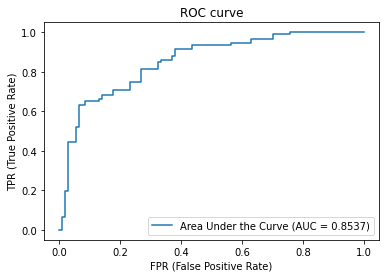

In [11]:
#scikit learn
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
%matplotlib inline
#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print ("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
#plt.savefig(path_experiment+"ROC.png")
plt.savefig('Enhancer-dataset-2-one-hot-code-ROC-Testing.png')
#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
#Confusion matrix
threshold_confusion = 0.5
#print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
#print (confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
#print ("Precision: " +str(precision))

#Jaccard similarity index
#jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
#print ("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

mcc= matthews_corrcoef(y_true, y_pred)
print ('MCC:', mcc)